# git2net analysis for the seaborn repository

First we import the required packages

In [12]:
import pygit2 as git2
import os
import shutil
import git2net
import pathpy as pp
import sqlite3
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import json 
import math
import copy

#git_repo_url = 'https://github.com/pandas-dev/pandas.git'
#git_repo_url = 'https://github.com/networkx/networkx.git'
#git_repo_url = 'https://github.com/numpy/numpy.git'
#git_repo_url = 'https://github.com/deepcharles/ruptures.git'
git_repo_url = 'https://github.com/mwaskom/seaborn.git'
repo_name = 'seaborn'
local_directory = '.'
git_repo_dir = 'repos/{r}4analysis'.format(r=repo_name)
sqlite_db_file = 'databases/{r}/{r}_rename.db'.format(r=repo_name)
#sqlite_db_file = 'databases/{r}/{r}.db'.format(r=repo_name)

Clone repo:

In [ ]:
if os.path.exists(git_repo_dir):
    shutil.rmtree(git_repo_dir)

repo = git2.clone_repository(git_repo_url, git_repo_dir) # Clones a non-bare repository

Then we create the database for it. We will try with max_modification=100, so that most commits are processed.

Mine repo:

In [ ]:
# Remove database if exists
#if os.path.exists(sqlite_db_file):
#    os.remove(sqlite_db_file)

max_modifications = 100
    
git2net.mine_git_repo(git_repo_dir, sqlite_db_file, max_modifications=max_modifications)

Let's check the commits that had more than 100 files modified

In [2]:
git2net.mining_state_summary(git_repo_dir, sqlite_db_file)

  0%|          | 0/6 [00:00<?, ?it/s]

492 / 498 (98.80%) of commits were successfully mined.


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


,hash,is_merge,modifications,author_name,author_email,author_date
0,c6062051483a44b9068c2c4203dc3eb2d1780156,False,193,Charles Truong,charles@doffy.net,2020-03-20 19:18:47
1,e5e82e79ab439b8306bf6097f9b7e21d4769b8d3,True,246,Charles T,charles@doffy.net,2020-03-20 19:20:59
2,86140d08a9c210259346d7d61af713e3a65651e1,True,247,Charles T,charles@doffy.net,2020-03-25 17:40:34
3,77359107e606b0d09c78c86b28dec5a31fb833a4,False,193,Charles Truong,charles@doffy.net,2020-08-04 17:29:26
4,a403c5a84e8632bb061c5ce6806bc45bca33cdd5,True,194,Charles T,charles@doffy.net,2020-08-04 17:34:11
5,373018430411fc20930f6dd175e7d37e0aa21395,True,152,Charles T,charles@doffy.net,2020-10-23 13:43:33


### Database modification
Replacing the duplicate names, then the names with numbers for compatibility with a temporal network.

In [13]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data

,index,hash,author_email,author_name,committer_email,committer_name,author_date,committer_date,author_timezone,committer_timezone,no_of_modifications,commit_message_len,project_name,parents,merge,in_main_branch,branches
0,0,31eda8fc053ff3aacc20e7c01570efac01c35db1,mwaskom@stanford.edu,1,mwaskom@stanford.edu,1,2012-06-18 12:30:41,2012-06-18 12:30:41,25200,25200,1,13,seaborn4analysis,36dd99374a1d6857af7652a9fb832a712a066e16,0,1,master
1,1,9caebbff04919e8db78baf544d825190d3fc49d8,mwaskom@stanford.edu,1,mwaskom@stanford.edu,1,2012-06-18 13:15:31,2012-06-18 13:15:31,25200,25200,1,31,seaborn4analysis,31eda8fc053ff3aacc20e7c01570efac01c35db1,0,1,master
2,2,f39de6924a5ae1d77c013177f177ac9f48e9a72f,mwaskom@stanford.edu,1,mwaskom@stanford.edu,1,2012-06-18 13:40:57,2012-06-18 13:40:57,25200,25200,1,24,seaborn4analysis,9caebbff04919e8db78baf544d825190d3fc49d8,0,1,master
3,3,22d9c3b4e73adc2f9699a4e00141373f695b8e2e,mwaskom@stanford.edu,1,mwaskom@stanford.edu,1,2012-06-18 16:19:02,2012-06-18 16:19:02,25200,25200,1,44,seaborn4analysis,f39de6924a5ae1d77c013177f177ac9f48e9a72f,0,1,master
4,4,36dd99374a1d6857af7652a9fb832a712a066e16,mwaskom@stanford.edu,1,mwaskom@stanford.edu,1,2012-06-18 11:40:27,2012-06-18 11:40:27,25200,25200,6,14,seaborn4analysis,,0,1,master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,2754,ba4bd0fa0a90b2bd00cb62c2b4a5e38013a73ac6,mwaskom@users.noreply.github.com,1,noreply@github.com,60,2021-03-06 17:26:32,2021-03-06 17:26:32,18000,18000,2,274,seaborn4analysis,b528ba272e2995c390fc84f13a49dd8de801121b,0,1,master
2755,2755,6183f1e3b0fc2b56ef441acfe1f9f63a13ae4beb,mwaskom@users.noreply.github.com,1,noreply@github.com,60,2021-02-09 19:01:13,2021-02-09 19:01:13,18000,18000,3,333,seaborn4analysis,b1dc1bc336ca2aec8308915836ec0550397e856e,0,1,master
2756,2756,a809747dad5f60be3260b3bdbb2cbc8d6135284a,mwaskom@users.noreply.github.com,1,noreply@github.com,60,2021-01-19 16:59:36,2021-01-19 16:59:36,18000,18000,13,1568,seaborn4analysis,aa488f0f96c22cad5f05998e60cce08a593422b8,0,1,master
2757,2757,0547bb1cef8f7a1d9080ec96bb99841afb6bdeba,mwaskom@users.noreply.github.com,1,noreply@github.com,60,2020-09-07 15:59:15,2020-09-07 15:59:15,14400,14400,43,856,seaborn4analysis,89f71465c76d447cc5a22e38e4d8813cba2f84dc,0,1,master


In [13]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data[['author_name', 'author_email']].drop_duplicates().sort_values(by=['author_name', 'author_email']).to_excel('databases/{r}/{r}_commits_authors.xlsx'.format(r=repo_name))
data[['committer_name', 'committer_email']].drop_duplicates().sort_values(by=['committer_name', 'committer_email']).to_excel('databases/{r}/{r}_commits_committers.xlsx'.format(r=repo_name))

In [16]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
data[['author_name', 'author_email']].drop_duplicates().sort_values(by=['author_name', 'author_email']).to_excel('databases/{r}/{r}_commits_authors.xlsx'.format(r=repo_name))
data[['committer_name', 'committer_email']].drop_duplicates().sort_values(by=['committer_name', 'committer_email']).to_excel('databases/{r}/{r}_commits_committers.xlsx'.format(r=repo_name))

with open('aliases/aliases-{r}.json'.format(r=repo_name)) as f:
    aliases = json.load(f)
    data = data.replace({'author_name': aliases})
    data = data.replace({'committer_name': aliases})
f.close()

rename_auth = {}
rename_committer = {}

i = 1
for name in data['author_name'].unique():
    rename_auth[name] = i
    i = i + 1

i = 1
for name in data['committer_name'].unique():
    rename_committer[name] = i
    i = i + 1

data = data.replace({'author_name': rename_auth})
data = data.replace({'committer_name': rename_committer})

f = open('databases/{r}/{r}_authors.json'.format(r=repo_name), 'w')
f.write(json.dumps(rename_auth))
f.close()

f = open('databases/{r}/{r}_committers.json'.format(r=repo_name), 'w')
f.write(json.dumps(rename_committer))
f.close()

data.to_sql('commits', con, if_exists='replace')

### Co-author networks

The network is too complex because we consider the whole timeframe of the repository since its creation. Therefore we need to filter the time dimensin, and in order to do that we nee to find the first and last commit in the repo.

In [6]:
db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

Min date:  2012-06-18 11:40:27
Max date:  2021-03-06 17:26:32


In order not to select an 'empty' time period (relatively few commits, e.g. holiday season), it's also worth observing the number of commits over time.

<BarContainer object of 3184 artists>

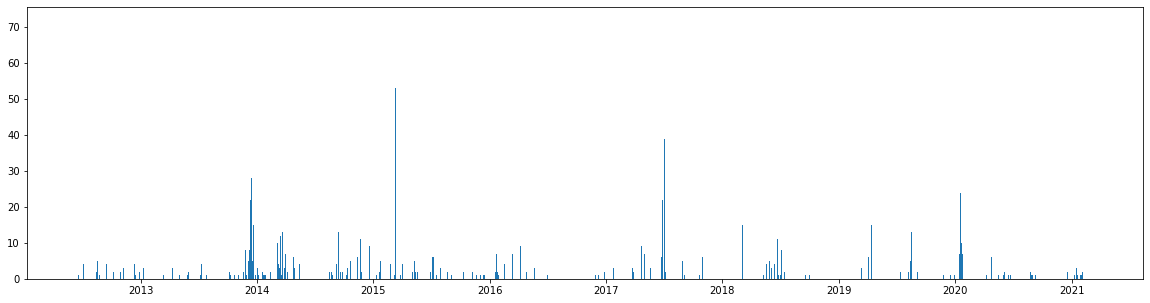

In [14]:
pdCommits = pd.read_sql_query("SELECT * FROM commits", db)

days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date).days + 1)}

commit_dates = pdCommits['committer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()).value_counts()

for key in commit_dates.keys():
    days[key] = commit_dates.get(key)

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
plt.bar(keys, values)

## Bipartite networks
Because our network changes over time, we would like to visualize each year consecutively one after the other. We can use the pathpy temporal networks for this. 

In [15]:
def collab_network(sqlite_db_file, t, node_info, min_date, max_date, file_base):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)

        new_n = copy.deepcopy(n)

        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)

        for node in new_n.nodes:
            for f in n.successors[node]:
                for pre in n.predecessors[f]:
                    if not node == pre:
                        new_n.add_edge(node, pre)

        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [ ]:
time_from = datetime(2014, 1, 1)
time_to = datetime(2014, 1, 31)
interval = timedelta(days=1)
delta = timedelta(days=1)

t2 = pp.TemporalNetwork()

rounds = math.ceil((time_to - time_from - interval)/delta)
for i in range(0,rounds):
    print('Round {i}/{r}'.format(i=i+1, r=rounds+1), end = "\r")
    start = time_from + i * delta
    end = time_from + i * delta + interval
    network = collab_network(sqlite_db_file, t, node_info, start, end, True)
    
    for edge in network.edges:
        print(edge)
        t2.add_edge(edge[0], edge[1], i)

style = {    
  'ts_per_frame': 1, 
  'ms_per_frame': 700,
  'look_ahead': 0, 
  'look_behind': 1, 
  'inactive_edge_width': 2,
  'active_edge_width': 4, 
  'label_color' : '#000000',
  'label_size' : '8px',
  'label_offset': [0,5]
  }
print('\n', t2)
#pp.visualisation.plot(t2, **style)

In [16]:
def export_networks(t, node_info, sqlite_db_file, time_from, time_to, interval, delta, file_mode, repo_name):
    if len(time_from) == len(time_to) == len(interval) == len(delta) == len(file_mode):
        for i in range(0,len(delta)-1):
            print('\nIteration {i}/{r}'.format(i=i+1, r=len(delta)))
            t2 = pp.TemporalNetwork()
            current_interval = timedelta(days=interval[i])
            current_delta = timedelta(days=delta[i])
            rounds = math.ceil((time_to[i] - time_from[i] - current_interval)/current_delta)
            for j in range(1,rounds+1):
                print('Round {j}/{r}'.format(j=j, r=rounds), end = "\r")
                start = time_from[i] + j * current_delta
                end = time_from[i] + j * current_delta + current_interval
                network = collab_network(sqlite_db_file, t, node_info, start, end, file_mode[i])

                for edge in network.edges:
                    edge_from = "{:.0f}".format(edge[0]) if type(edge[0]) is float or type(edge[0]) is int else edge[0]
                    edge_to   = "{:.0f}".format(edge[1]) if type(edge[1]) is float or type(edge[1]) is int else edge[1]
                    t2.add_edge(edge_from, edge_to, j)

            style = {    
              'ts_per_frame': 1, 
              'ms_per_frame': 700,
              'look_ahead': 0, 
              'look_behind': 1, 
              'inactive_edge_width': 2,
              'active_edge_width': 4, 
              'label_color' : '#000000',
              'label_size' : '8px',
              'label_offset': [0,5]
              }
            pp.visualisation.export_html(t2, 'exports/{r}/{r}_tf{tf}_tt{tt}_i{i}_d{d}_{f}.html'.format(
                r=repo_name,
                tf=time_from[i].strftime('%Y%m%d'),
                tt=time_to[i].strftime('%Y%m%d'),
                i=interval[i],
                d=delta[i],
                f='f' if file_mode[i] else 'l'
            ), **style)
    else:
        raise ValueError
    print('\nFinished exporting!')

In [10]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)

In [17]:
time_from = [datetime(2014, 1,  1), datetime(2014, 1, 1), datetime(2014, 1,  1), datetime(2014,  1,  1), datetime(2014,  1,  1), datetime(2014,  1,  1), datetime(2014,  1,  1)]
time_to   = [datetime(2014, 1, 31), datetime(2014, 2, 6), datetime(2014, 2, 13), datetime(2014, 12, 31), datetime(2014, 12, 31), datetime(2015, 12, 31), datetime(2016, 12, 31)]
interval  = [1, 7, 14, 30, 60, 30, 60]
delta     = [1, 1,  1,  7,  7, 14, 14]
file_mode = [False, False, False, False, False, False, False]

export_networks(t, node_info, sqlite_db_file, time_from, time_to, interval, delta, file_mode, repo_name)


Iteration 1/7
Round 29/29
Iteration 2/7
Round 29/29
Iteration 3/7
Round 29/29
Iteration 4/7
Round 48/48
Iteration 5/7
Round 44/44
Iteration 6/7
Round 50/50
Finished exporting!


In [20]:
n = pp.Network.from_temporal_network(t)
n.edges

defaultdict(dict,
            {(1, 'rcmod.py'): {'weight': 88.0},
             (1, '.gitignore'): {'weight': 26.0},
             (1, 'README.rst'): {'weight': 3.0},
             (1, '__init__.py'): {'weight': 57.0},
             (1, 'setup.py'): {'weight': 62.0},
             (1, 'test_utils.py'): {'weight': 40.0},
             (1, 'utils.py'): {'weight': 88.0},
             (1, 'README.md'): {'weight': 57.0},
             (1, 'plotobjs.py'): {'weight': 143.0},
             (1, 'linear_models.ipynb'): {'weight': 48.0},
             (1, 'example_plot.png'): {'weight': 21.0},
             (1, 'example_plot.py'): {'weight': 19.0},
             (1, 'plotting_distributions.ipynb'): {'weight': 40.0},
             (1, 'timeseries_plots.ipynb'): {'weight': 23.0},
             (2, 'requirements.txt'): {'weight': 1.0},
             (1, 'requirements.txt'): {'weight': 10.0},
             (1, 'Makefile'): {'weight': 47.0},
             (1, 'ipnbdoctest.py'): {'weight': 23.0},
             (1, 'con

In [21]:
git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)

Help on function get_coauthorship_network in module git2net.visualisation:

get_coauthorship_network(sqlite_db_file, time_from=None, time_to=None)
    Returns coauthorship network containing links between authors who coedited at least one code
        file within a given time window.
    
        Node and edge infos set up to be expanded with future releases.
    
    Args:
        sqlite_db_file: path to sqlite database
        time_from: start time of time window filter, datetime object
        time_to: end time of time window filter, datetime object
    
    Returns:
        n: pathpy network
        node_info: info on node charactaristics
        edge_info: info on edge characteristics

